In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Load data
df = pd.read_csv(r"D:\JOB\1 Pricing analyst\1 Price elasticity & demand forecasting\2 Time series\time_series_dataset.csv")


In [ ]:
# prepare data
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df.set_index("date", inplace=True)
df = df.asfreq("D")  # Set daily frequency

In [ ]:
# Step 1: Decompose to visualize trend, seasonality, residual
decomposition = seasonal_decompose(df["demand"], model="additive", period=7)  # weekly seasonality
decomposition.plot()
plt.suptitle("Seasonal Decomposition")
plt.show()

In [5]:
# Step 2: ADF test on original series
result = adfuller(df["demand"].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] > 0.05:
    print("❌ Non-stationary — apply differencing")
else:
    print("✅ Stationary")

ADF Statistic: -1.2479315163100617
p-value: 0.6526446633954118
❌ Non-stationary — apply differencing


In [6]:
# Step 3: Difference if needed (trend & seasonal)
df["demand_diff"] = df["demand"].diff().dropna()
df["demand_seasonal_diff"] = df["demand"].diff(7).dropna()

In [7]:
# ADF test on differenced series
result = adfuller(df["demand_seasonal_diff"].dropna())
print(f"\nADF after seasonal differencing: {result[0]}")
print(f"p-value: {result[1]}")


ADF after seasonal differencing: -7.389516792597971
p-value: 8.069796912116812e-11


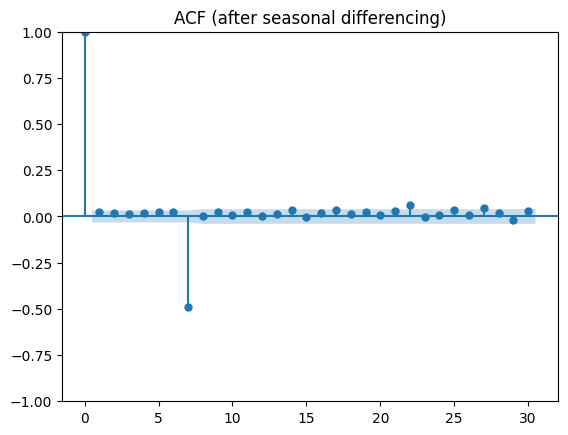

In [8]:
# Step 4: ACF and PACF (to choose p, q and P, Q)
plot_acf(df["demand_seasonal_diff"].dropna(), lags=30)
plt.title("ACF (after seasonal differencing)")
plt.show()

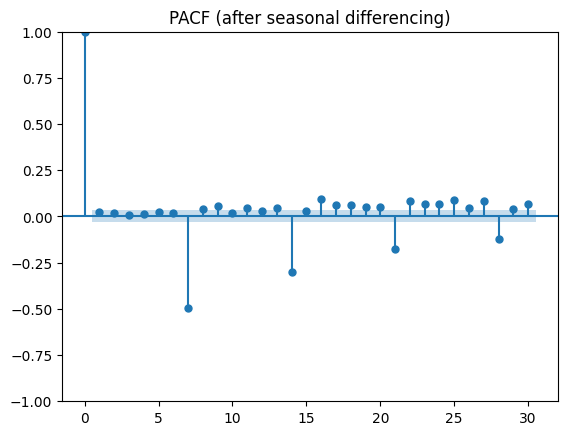

In [9]:
plot_pacf(df["demand_seasonal_diff"].dropna(), lags=30)
plt.title("PACF (after seasonal differencing)")
plt.show()

In [10]:
# Step 5: Train-test split
train = df["demand"][:-180]
test = df["demand"][-180:]

In [ ]:
# Step 6: Fit SARIMA model — example (you may adjust based on ACF/PACF)
model = SARIMAX(train, 
                order=(1, 1, 1),         # (p, d, q)
                seasonal_order=(1, 1, 1, 180),  # (P, D, Q, S) → weekly
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit()

In [ ]:
# Step 7: Forecast
forecast = model_fit.forecast(steps=180)
forecast.index = test.index

In [ ]:
# Step 8: Plot forecast vs actual
plt.figure(figsize=(10,4))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual")
plt.plot(forecast.index, forecast, label="Forecast")
plt.title("SARIMA Forecast vs Actual Demand")
plt.legend()
plt.show()

In [ ]:
# Step 9: Evaluate
rmse = sqrt(mean_squared_error(test, forecast))
print(f"✅ RMSE: {rmse:.2f}")